Imports

In [3]:
# ! pip install scikit-learn==1.1.3

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix

In [2]:
import matplotlib.pyplot as plt

In [5]:
from bedmap.bedmap import ClassifyBedforms
from bedmap.utilities import plot_rate_matrix, thresh

In [6]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Import the Ground Truth Data

In [7]:
data = pd.read_csv('data/TPI_processed.csv')

In [8]:
measured_bedforms = np.array(data['Y/N'])

In [9]:
type(measured_bedforms)

numpy.ndarray

## Bring in the ground truth and estimated bedforms

Estimate the bedforms using the RF model.

In [10]:
bedforms = ClassifyBedforms('data/TPI_processed.csv',
                            model='random_forest', 
                            threshold=0.5, probability=False)

In [11]:
estimated_bedforms = bedforms.predicted_bedforms

In [12]:
type(estimated_bedforms)

numpy.ndarray

## Measure Performance Scores for the Random Forest Model Fit

Performance metric are established, quantitative measures used to assess the effectiveness or quality of model predictions in machine learning tasks. We'll be using metrics available in the `sklearn` library.

We'll start with the most straightforward measure, called "accuracy," which measures the ratio of correctly classified instances over all instances. The equation is (Number of True Positives + Number of True Negatives)/(Number of all Predictions).

In [13]:
accuracy = accuracy_score(measured_bedforms, estimated_bedforms)
print("Accuracy:", accuracy)

Accuracy: 0.8504898741824486


"Precision" is also a commonly used metric, and measures the ratio of true positives to all predicted positives. The equation is (Number of True Positives)/(Number of True Positives + Number of False Positives).

In [14]:
precision = precision_score(measured_bedforms, estimated_bedforms)
print("Precision:", precision)

Precision: 0.5909451046972269


"Recall" measures the ratio of actual positives that are correctly identified by the classifier while accounting for positives missed by the classifier. It's calculated as (Number of True Positives)/(Number of True Positives + Number of False Negatives). Recall can be used to optimize in CV when the cost of false negatives is high, i.e. when a model has a tendency to underpredict, which the current state of our model does.

In [15]:
recall = recall_score(measured_bedforms, estimated_bedforms)
print("Recall:", recall)

Recall: 0.7153034662282505


The "F1 score" is the harmonic mean between precision and recall. This means that an F1 score provides a balanced measure between precision and recall tipped towards the lower score, making it a useful metric for evaluating classifiers in situations where you want to consider both false positives and false negatives equally.

In [16]:
f1 = f1_score(measured_bedforms, estimated_bedforms)
print("F1 Score:", f1)

F1 Score: 0.647204660964423


Finally, the assessment that you might have seen in other papers, the "confusion matrix." The confusion matrix is nice because it allows for easy visualization of the model performance. In our case of binary classficiation, it is a 2x2 matrix showing number of true positives, number of false positives, number of true negatives, and number of false negatives. It can also be measured using `sklearn`.

In [17]:
conf_matrix = confusion_matrix(measured_bedforms, estimated_bedforms)

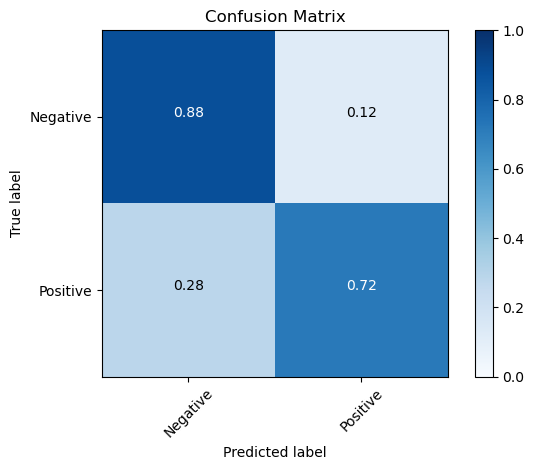

In [18]:
plot_rate_matrix(conf_matrix)

This shows that we're really good at predicting when something isn't a bedform, but we aren't that great at predicting when something *is* a bedform. This is definitely something that we want to improve on, and we can increase this improvement through CV. We'll re-run our cross validation, and instead of relying on accuracy, which is weighted by how many true negatives we are measuring, we'll weight on F1 score and see how this improves our model fit.

## Visualizing the ROC Curve and F1 Score for the Ensemble Average Fit

In [19]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay

In [20]:
bedforms = ClassifyBedforms('data/TPI_processed.csv',
                            model='ensemble_average', 
                            threshold=0.45, probability=True)

In [21]:
estimated_bedforms = bedforms.predicted_bedforms

Calculate ROC curves and AUCs for the model

In [26]:
fpr, tpr, _ = roc_curve(measured_bedforms, estimated_bedforms)
roc_auc_ens = auc(fpr, tpr)

Calculate F1 score at all probability thresholds

In [27]:
thresholds = np.concatenate((np.arange(0.01,0.1,0.01), np.arange(0.1,0.9,0.05), np.arange(0.9,1,0.01)))
thresh_arrays = np.zeros((len(thresholds),len(estimated_bedforms)))

for idx in range(len(thresh_arrays)):
    thresh_arrays[idx] =  thresh(estimated_bedforms, thresholds[idx])

In [28]:
f1s = np.zeros(len(thresholds))

for idx in range(len(thresholds)):
    f1s[idx] = f1_score(measured_bedforms, thresh_arrays[idx])

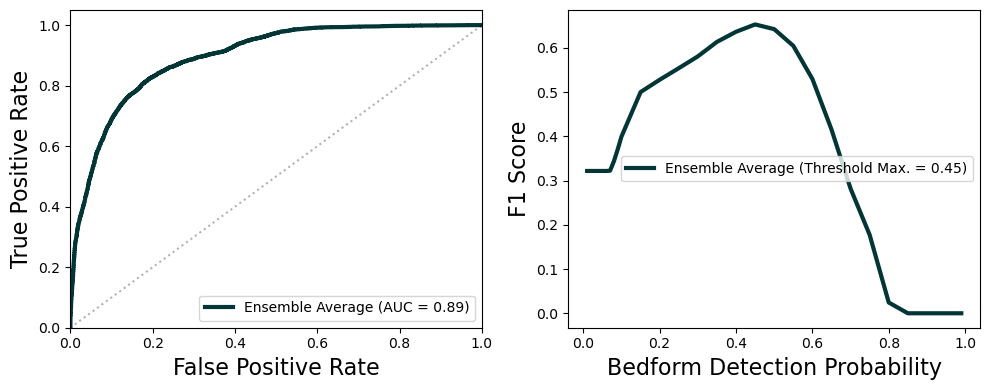

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(fpr, tpr, 
             color='#023535', lw=3,
             label='Ensemble Average (AUC = %0.2f)' % roc_auc_ens)

axs[0].plot([0, 1], [0, 1], color='k', 
             linestyle=':', alpha=0.3)
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate', fontsize=16)
axs[0].set_ylabel('True Positive Rate', fontsize=16)
axs[0].legend(loc="lower right")

# Right plot
axs[1].plot(thresholds, f1s, 
            color='#023535', lw=3,
            label='Ensemble Average (Threshold Max. = %0.2f)' % thresholds[np.argmax(f1s)])
axs[1].legend()
axs[1].set_xlabel('Bedform Detection Probability', fontsize=16)
axs[1].set_ylabel('F1 Score', fontsize=16)

plt.tight_layout()

Look at the confusion matrices as a function of probability thresholds.

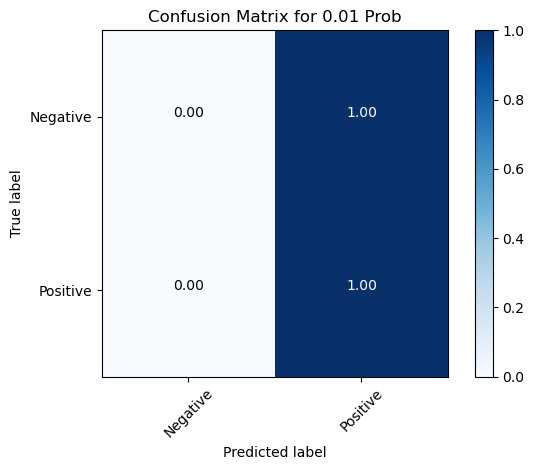

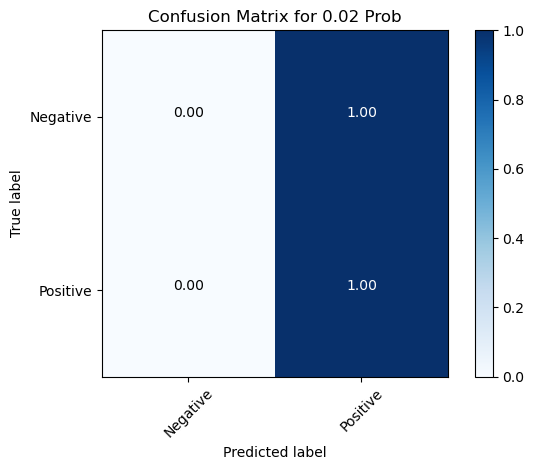

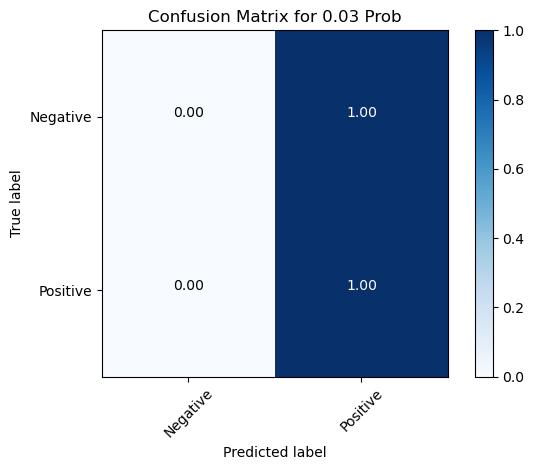

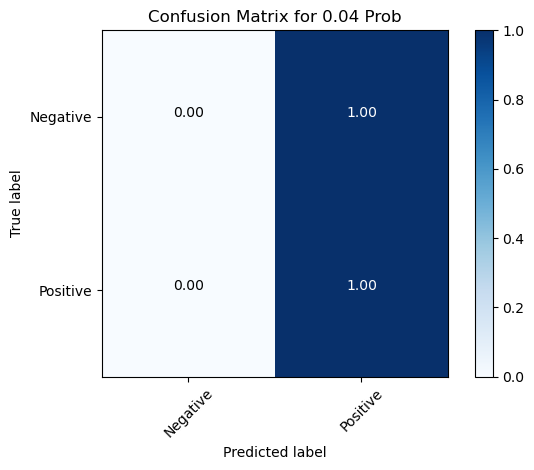

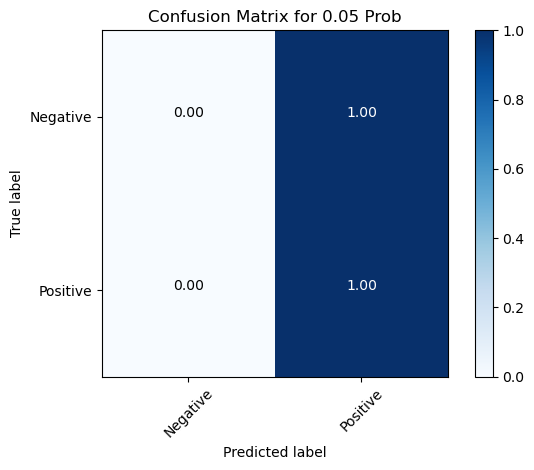

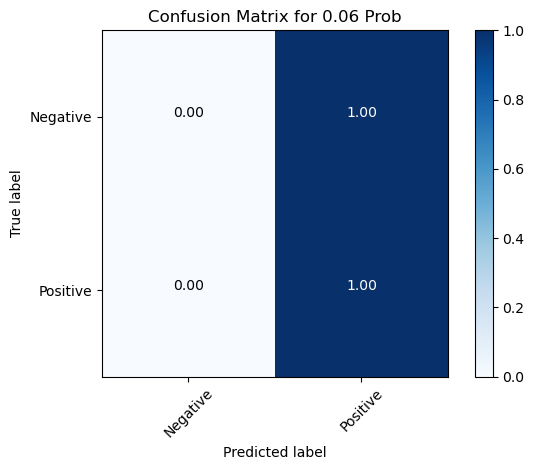

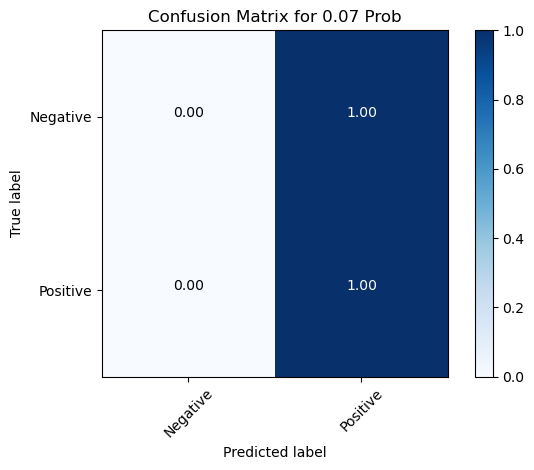

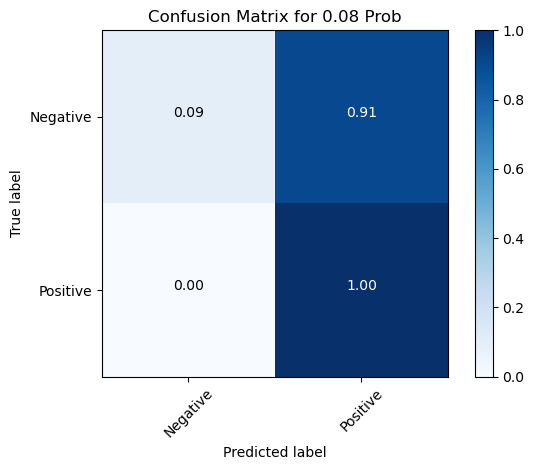

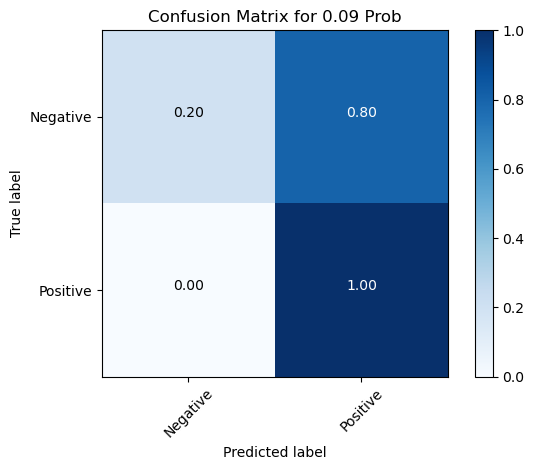

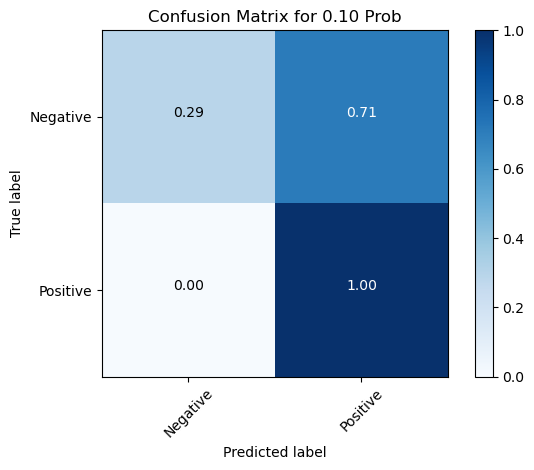

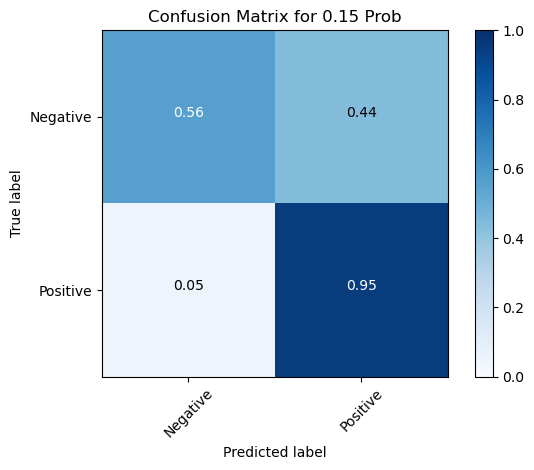

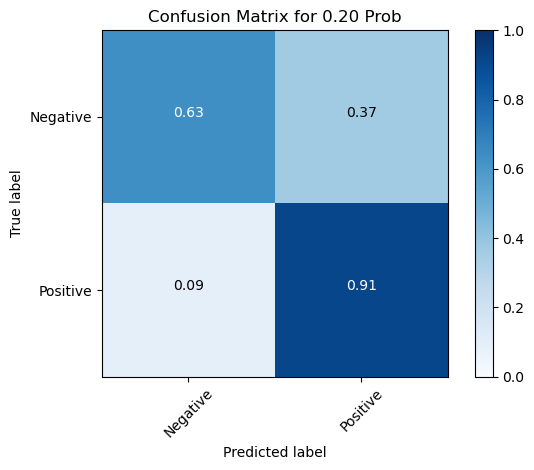

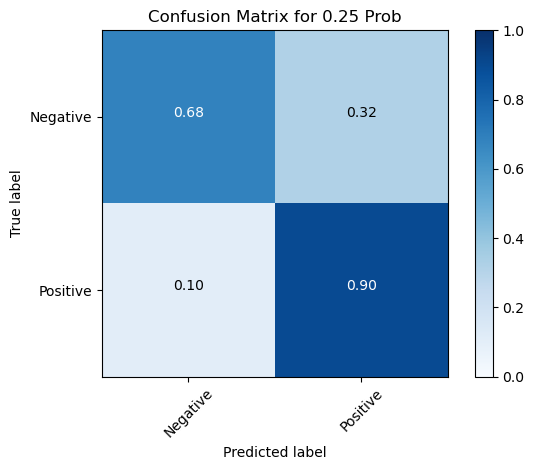

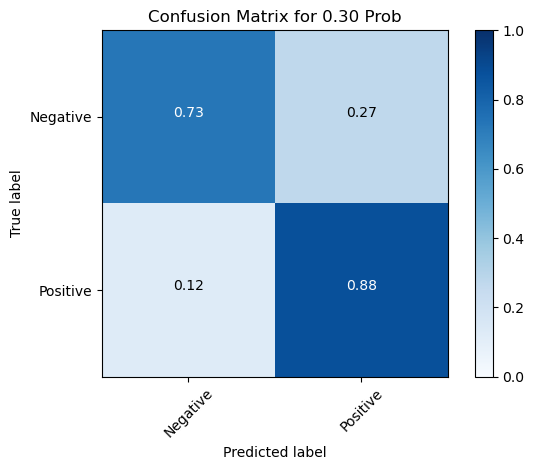

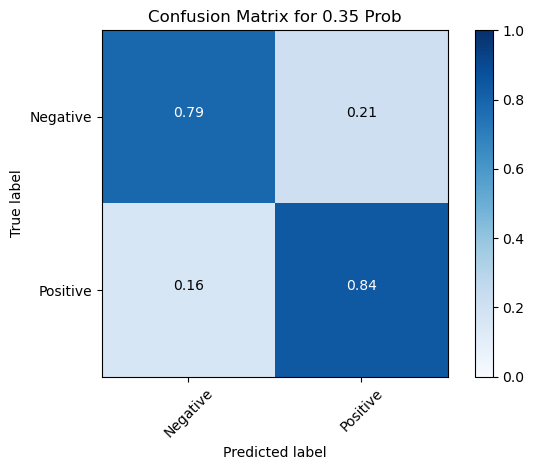

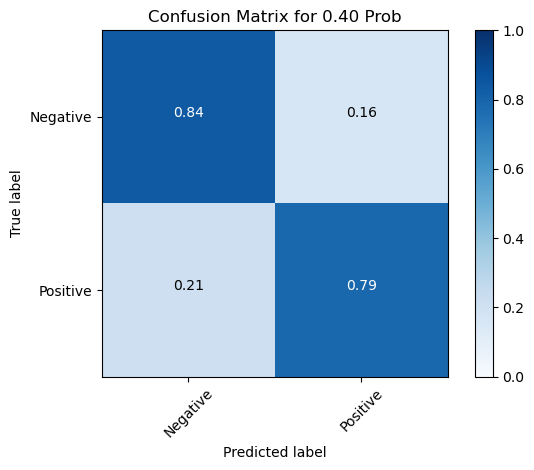

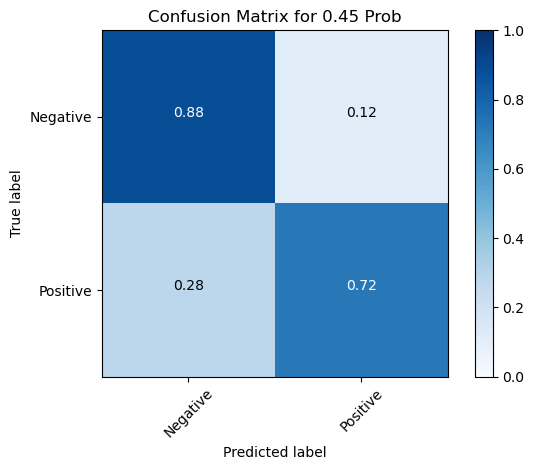

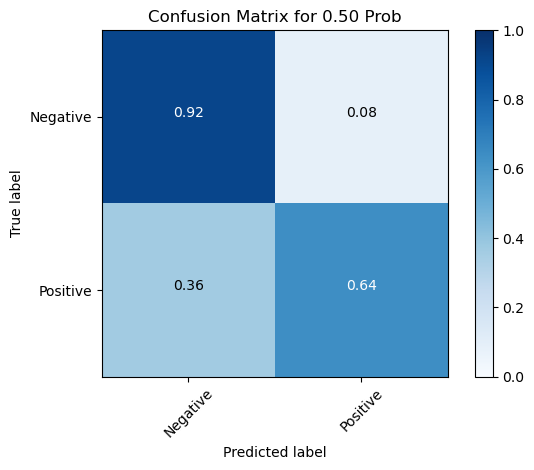

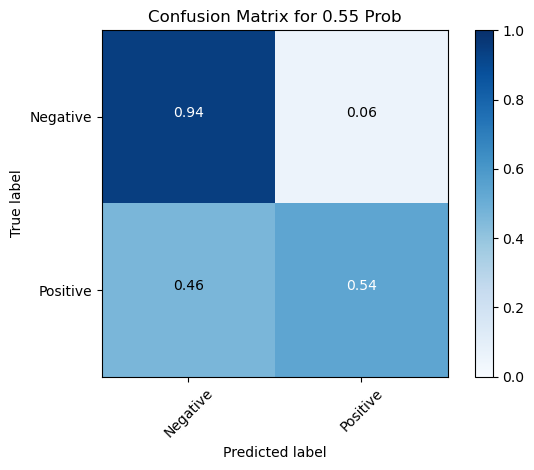

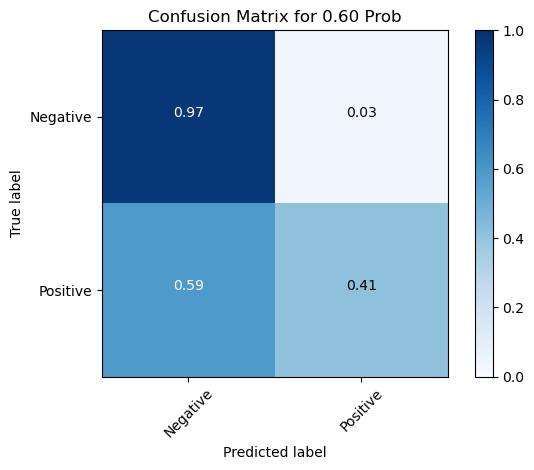

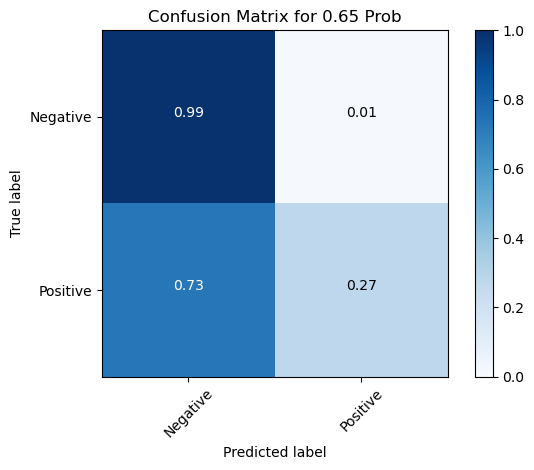

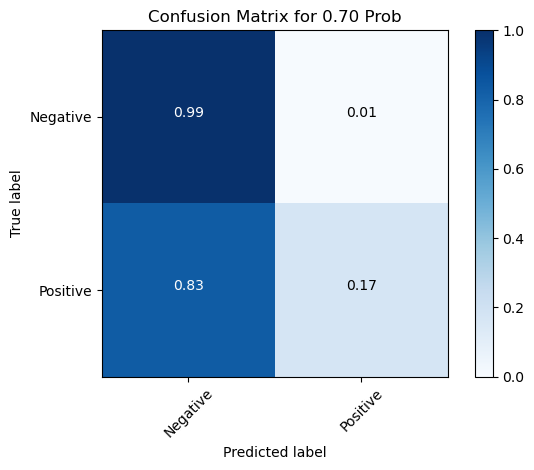

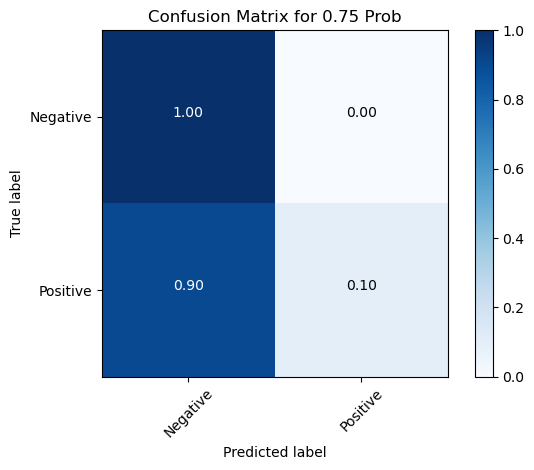

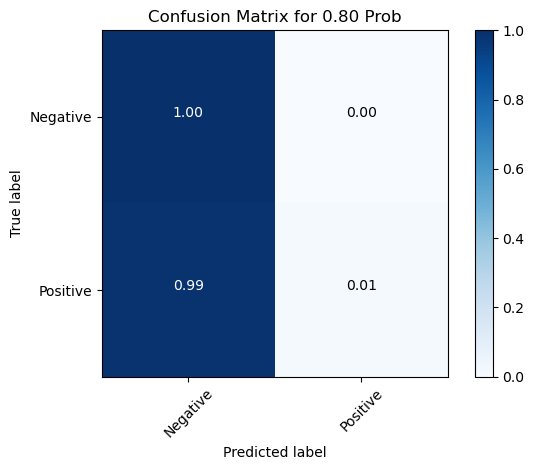

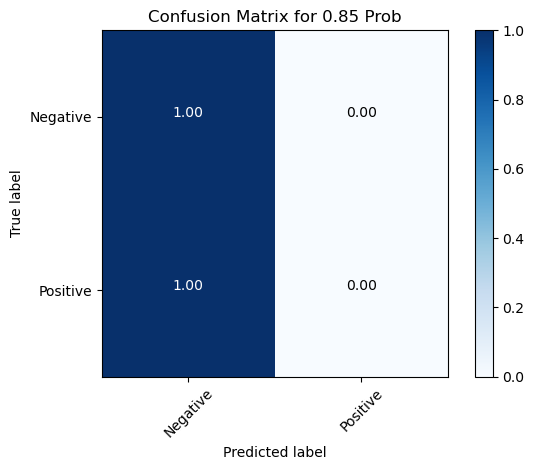

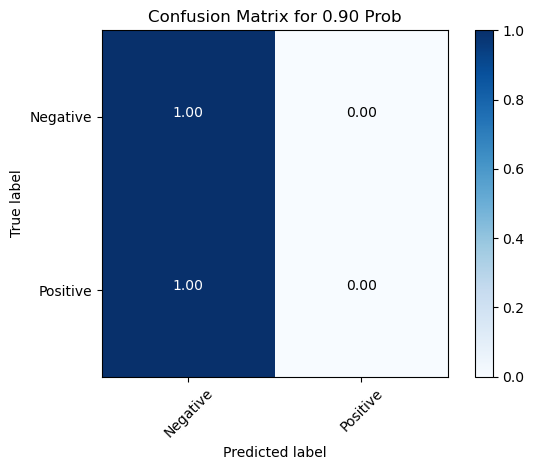

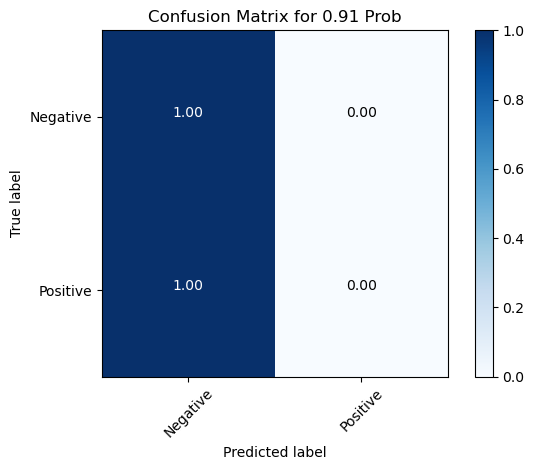

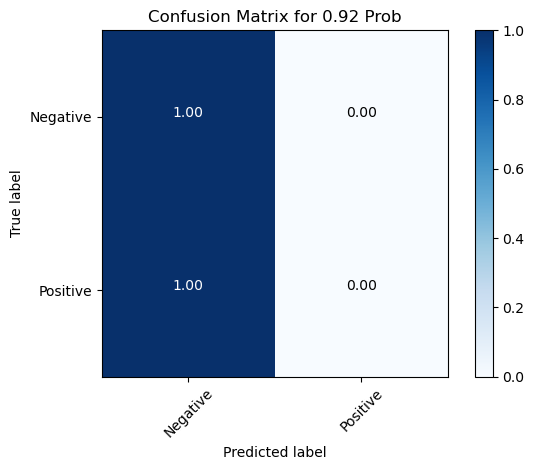

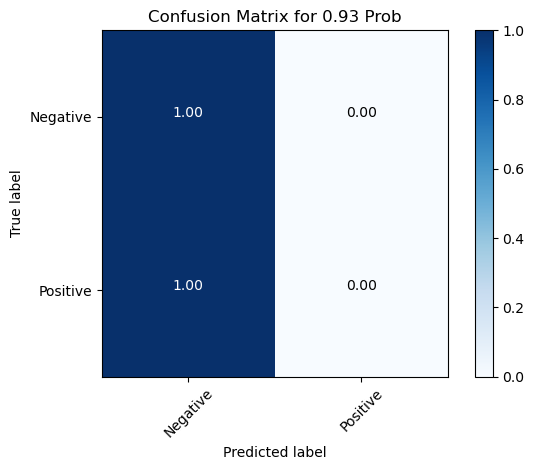

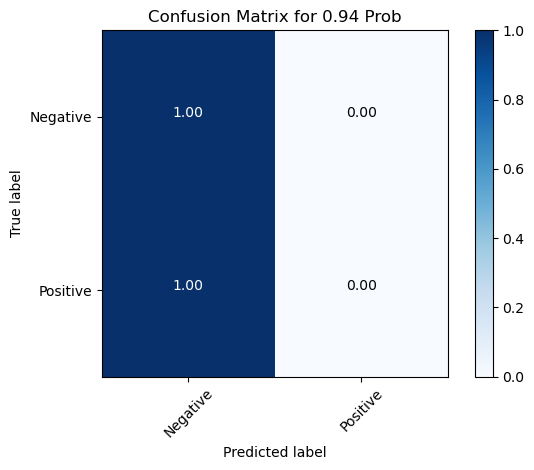

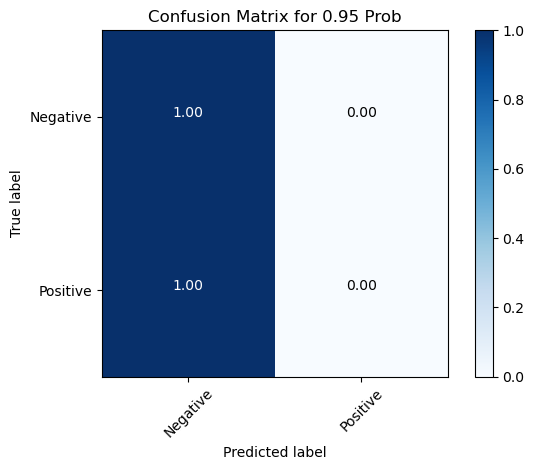

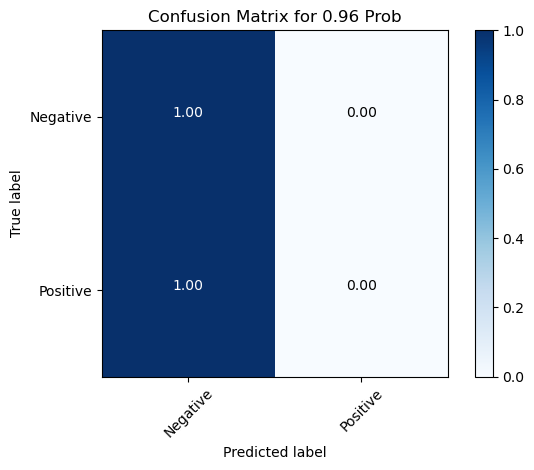

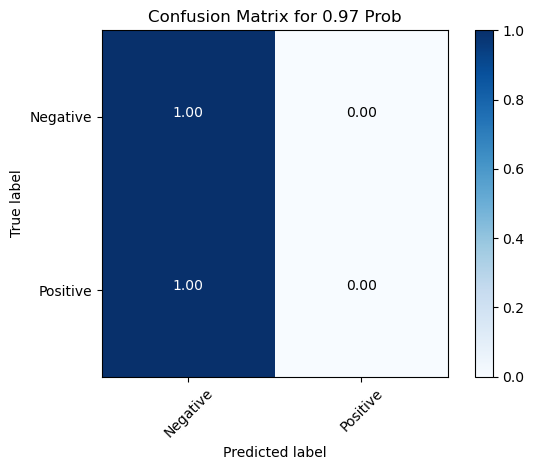

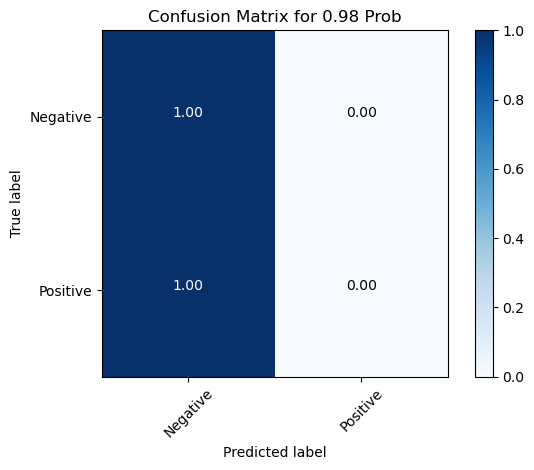

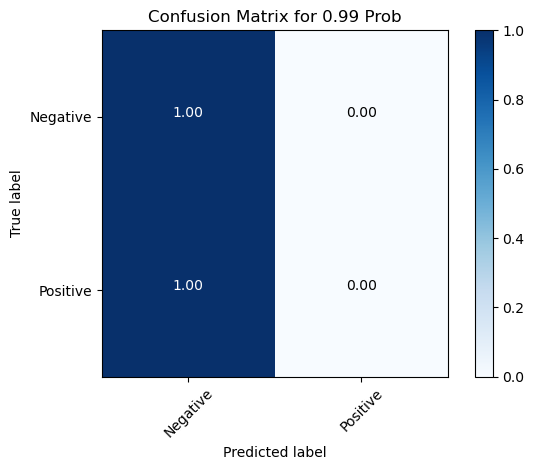

In [30]:
for idx in range(len(thresh_arrays)):
    conf_matrix = confusion_matrix(measured_bedforms, thresh_arrays[idx])
    title = f'Confusion Matrix for {float(thresholds[idx]):.2f} Prob'
    plot_rate_matrix(conf_matrix, title)